# Decision Trees and Random Forests

## Decision Trees

**Overview**
* Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero-in on the classification.
* The trick comes in deciding which questions to ask at each step. In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
* Except for nodes that contain all of one color, at each level every region is again split along one of the two features.

### Coding Example: Self-made data with make_blobs

In [1]:
# Importing the basic libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

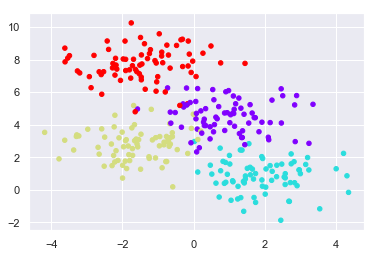

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='rainbow');

In [21]:
# Controlling the depth of the decision tree
depth = 6

In [22]:
# 1. choose model class
from sklearn.tree import DecisionTreeClassifier
# 2. instantiate model and fit model to the data
tree = DecisionTreeClassifier(max_depth=depth).fit(X, y) 

In [23]:
# Defining a visualization function
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

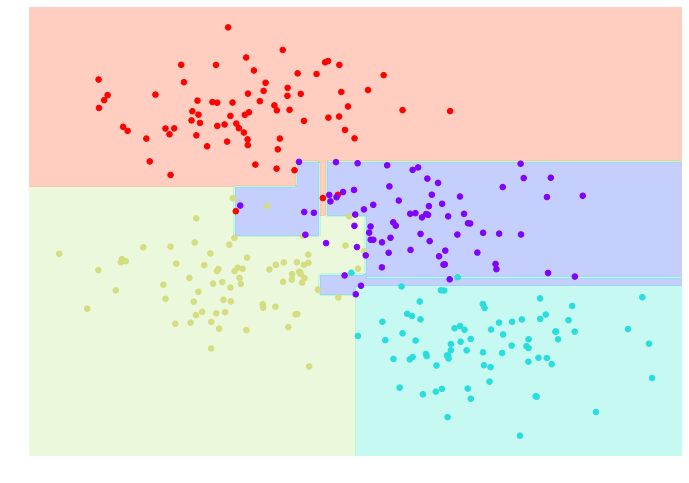

In [24]:
# Calling the visualization function for the decision tree
sns.set(rc={'figure.figsize':(11.7,8.27)})
visualize_classifier(DecisionTreeClassifier(max_depth=depth), X, y)

Over-fitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions they are drawn from.

## Random Forests (Classification)

**Overview**
* Non-parametric algorithm
* Ensemble method: It relies on aggregating the results of an ensemble of simpler estimators
* The surprising result with such ensemble methods is that the sum can be greater than the parts: that is, a majority vote among a number of estimators can end up being better than any of the individual estimators doing the voting!
* This notion - that multiple overfitting estimators can be combined to reduce the effect of this overfitting - is what underlies an ensemble method called bagging. __Bagging makes use of an ensemble of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.__ An ensemble of randomized decision trees is known as a random forest.

**Advantages**

* Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
* The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the predict_proba() method).
* The nonparametric model is extremely flexible, and can thus perform well on tasks that are under-fit by other estimators.

**Disadvantages**

* Results are not easily interpretable: that is, if you would like to draw conclusions about the meaning of the classification model, random forests may not be the best choice.

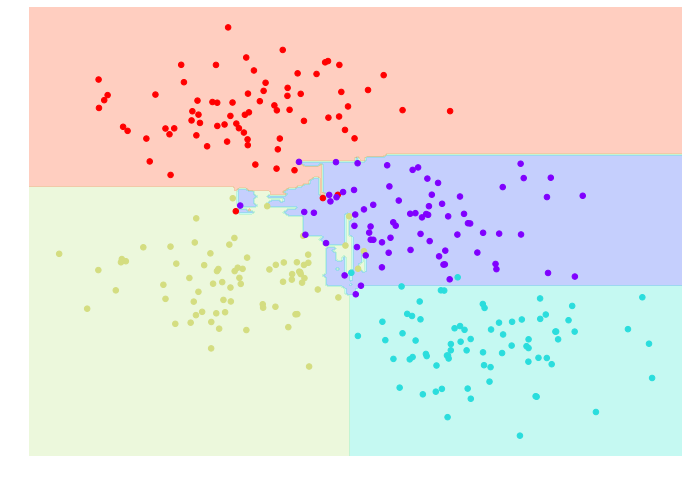

In [25]:
# Bagging done manually by using the BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points. In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the RandomForestClassifier estimator, which takes care of all the randomization automatically. All you need to do is select a number of estimators, and it will very quickly (in parallel, if desired) fit the ensemble of trees:

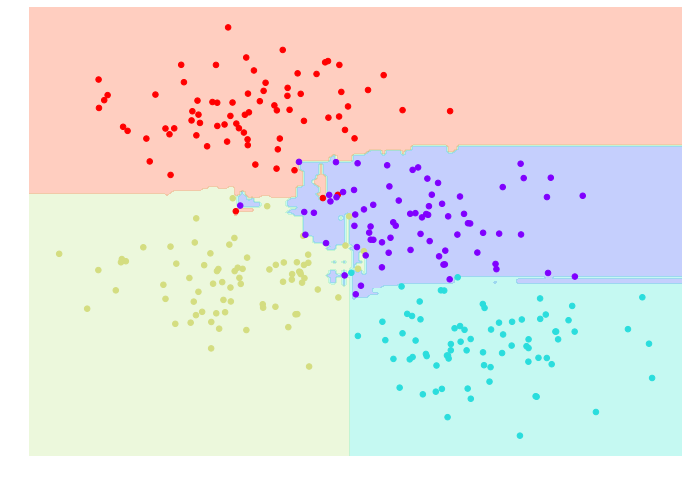

In [27]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
visualize_classifier(model, X, y);

It can be seen that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

### Coding Example: Classifying Digits

The random forest classifier can be used for classifying the hand-written digits from the sklearn datasets:

In [30]:
# Importing the dataset and printing the keys:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])

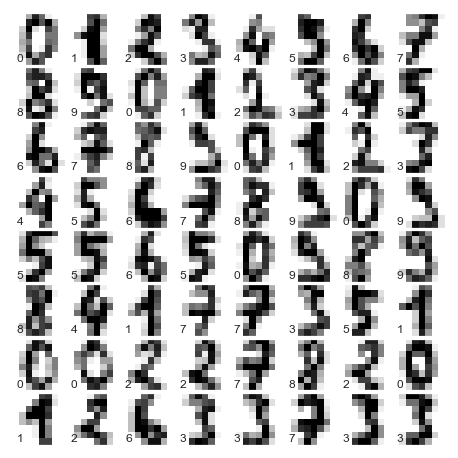

In [31]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

In [33]:
# Importing, training and testing the model:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

In [34]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

   micro avg       0.98      0.98      0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



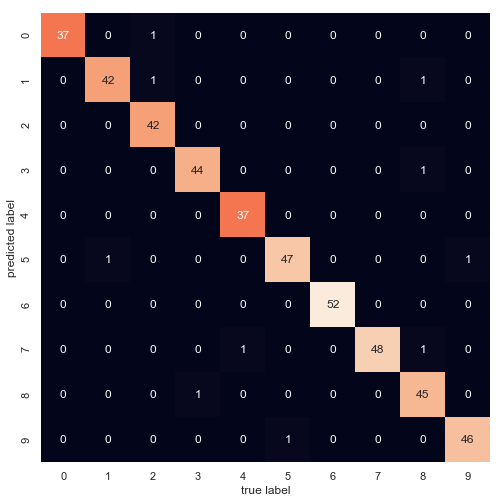

In [35]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [36]:
from sklearn.metrics import accuracy_score
accuracy_score(ytest, ypred)

0.9777777777777777

## Random Forests (Regression)

Random forests can also be made to work in the case of regression (that is, continuous rather than categorical variables). The estimator to use for this is the RandomForestRegressor.

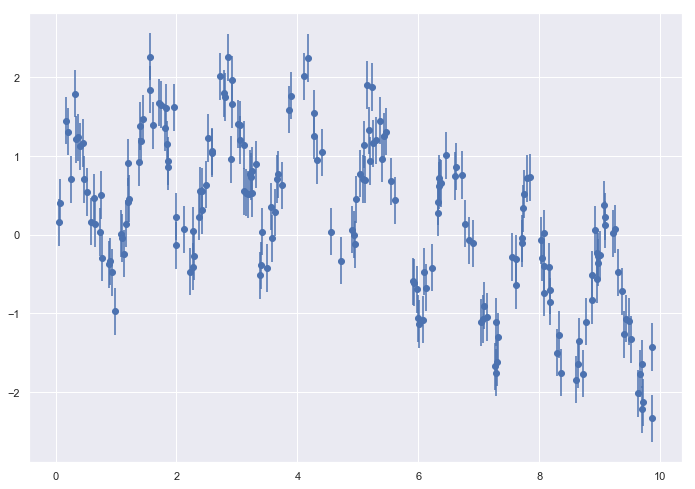

In [28]:
# Creating some random data based on a combination 
# of a fast and slow oscillation:

rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

The random forest regressor is used to find the best fit curve:

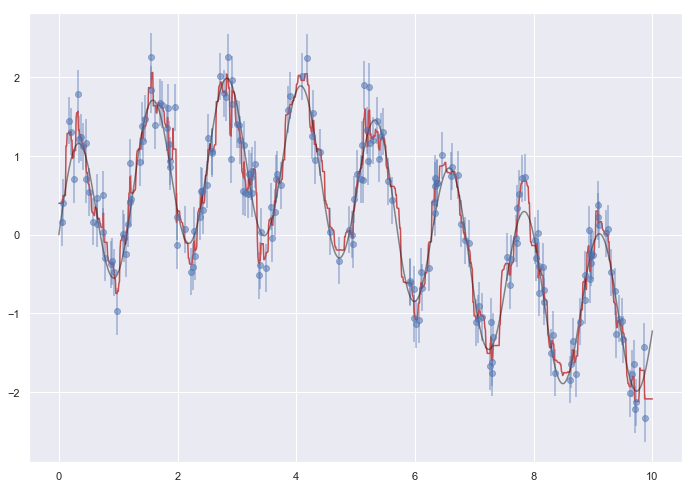

In [29]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

The true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve. It can be seen that the non-parametric random forest model is flexible enough to fit the multi-period data, without us needing to specifying a multi-period model!